In [10]:
% matplotlib inline
print("Hello, HW 02!")

Hello, HW 02!


# k-means
Реализуйте алгоритм k-means для кластеризации на 2-4 кластера.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

filename='blobs.csv'

def get_points(filename='blobs.csv'):
    df = pd.read_csv(filename)
    points = df.values
    return points


In [217]:
points = get_points()

In [218]:
def k_means(points, k):
    def get_rand_k_points(k, mtx):
        return mtx[np.random.randint(mtx.shape[0], size=k)]

    max_iters = 100
    tolerance = 0.000000001

    old_centroids = get_rand_k_points(k, points)
    new_centroids = old_centroids
    clusters = []
    delta = None

    for i in range(max_iters):
        dsts = cdist(points, new_centroids)

        ix_min = np.argmin(dsts, axis=1)

        cluster_masks = [(ix_min == x) for x in range(k)]

        clusters = [points[cluster_mask] for cluster_mask in cluster_masks]
        old_centroids = new_centroids
        new_centroids = np.array([np.mean(cluster, axis=0)
                                  for cluster in clusters])

        delta = np.max(new_centroids - old_centroids)
        if delta < tolerance:
            print("last iter = " + str(i))
            break

    return clusters


def run_k_means(points, k):
    clusters = k_means(points, k)

    X = [cluster[:, 0] for cluster in clusters]
    Y = [cluster[:, 1] for cluster in clusters]
    colors = ['red', 'blue', 'green', 'yellow', 'orange']
    assert k <= len(colors)

    for i in range(k):
        plt.plot(X[i], Y[i], 'o', color=colors[i])


last iter = 7


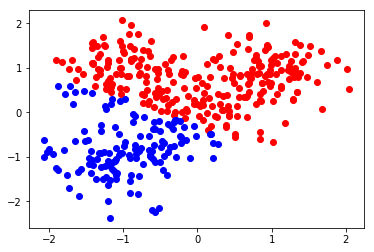

In [219]:
run_k_means(points, 2)

last iter = 3


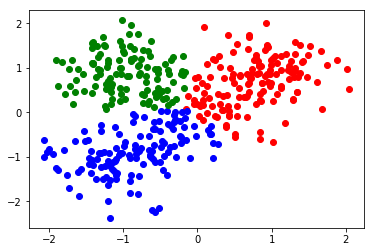

In [220]:
run_k_means(points, 3)

last iter = 7


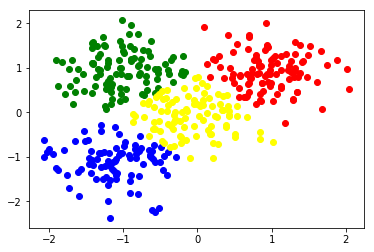

In [221]:
run_k_means(points, 4)

# DBSCAN
Реализуйте алгоритм DBSCAN, найдите параметр ε для кластеризации на 4 кластера.

In [222]:
# ######################################################
# https://youtu.be/kjbZLMW6Wic?t=3968 -- it helps
from typing import List


def neighbours(dist: np.ndarray, ix: int, eps: float) -> List[int]:
    # print("def neighbours(...)")
    cur_dist = dist[ix]
    indices = []
    for j in range(cur_dist.shape[0]):
        if j == ix:
            continue
        if cur_dist[j] < eps:
            indices.append(j)
    return indices


def expand_cluster(ix: int, points: np.ndarray, neighbr_ixes: List[int],
                   new_cluster: list, eps: float, min_pts: int,
                   visited: List[bool], dist: np.ndarray,
                   clusters_map: List[int]):
    # print("def expand_cluster(...)")
    new_cluster.append(points[ix])
    clusters_map[ix] = ix

    for n_ix in neighbr_ixes:
        # print(n_ix)
        if not visited[n_ix]:
            visited[n_ix] = True
            nbr_of_nbr = neighbours(dist, n_ix, eps)

            if len(nbr_of_nbr) >= min_pts:
                neighbr_ixes.extend(nbr_of_nbr)

            if clusters_map[n_ix] == -1:  # not in any cluster yet
                new_cluster.append(points[n_ix])
                clusters_map[n_ix] = ix


def dbscan(points: np.ndarray, eps: float, min_pts: int) -> (list, list):
    print("def dbscan(...)")
    N = points.shape[0]
    visited = [False for i in range(N)]  # not visited

    dist = cdist(points, points)
    clusters_map = [-1 for i in range(N)]

    noise = []
    clusters = []
    for i in range(points.shape[0]):
        if visited[i]:
            continue
        visited[i] = True  # mark as visited
        nbr_ix = neighbours(dist, i, eps)  # get indices of neighbours
        if len(nbr_ix) < min_pts:
            noise.append(points[i])

        else:  # this is new cluster
            new_cluster = []
            expand_cluster(i, points, nbr_ix, new_cluster, eps, min_pts,
                           visited, dist, clusters_map)
            clusters.append(new_cluster)

    return clusters, noise

In [223]:
# clusters, noise = dbscan(points, 0.25, 10)
# clusters -- list of points - list of clusters
# noise -- list of points

def launch_dbscan(points: np.ndarray, eps: float, min_pts: int):
    clusters, noise = dbscan(points, eps, min_pts)
    print("points: 400")
    print("clusters: " + str(len(clusters)))
    print("noise elements: " + str(len(noise)))
    
    Xs = [np.array(cluster)[:, 0] for cluster  in clusters]
    Ys = [np.array(cluster)[:, 1] for cluster  in clusters]
    
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'pink', 'black', 'purple', 'magenta', 'darl blue']
    assert len(clusters) <= len(colors)

    for i in range(len(clusters)):
        plt.plot(Xs[i], Ys[i], 'o', color=colors[i])
    
    if len(noise):
        noiseX = np.array(noise)[:, 0]    
        noiseY = np.array(noise)[:, 1]
        plt.plot(noiseX, noiseY, 'v', color='grey')


Я не понял, как подбирать параметры -- у нас же два параметра, а не один, верно? 

Я в итоге руками подбирал, это ведь ОК?

def dbscan(...)
points: 400
clusters: 4
noise elements: 111


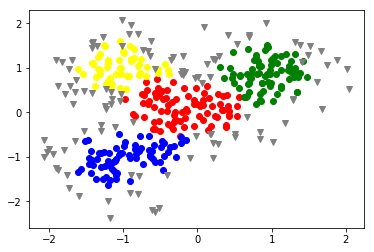

In [269]:
launch_dbscan(points, 0.3386, 20)

Серые треугольники - это шум.

# Affinity propagation
Реализуйте алгоритм Аffinity Propagation, найдите параметры для кластеризации на < 4,
4, >4 классов.

In [624]:
#############################################################################
# ###########################################################################

def recalc_R(R: np.ndarray, S: np.ndarray, A: np.ndarray, N: int,
             damping: float):
    AplusS = A + S

    # по всем строкам
    for i in range(N):
        # найдем 2 максимальных значения в строке - их индексы
        idx_top2 = np.argpartition(AplusS[i], -2)[-2:]
        ix_max1 = idx_top2[0]
        ix_max2 = idx_top2[1]

        # сделаем так, что первый индекс - индекс максимума
        if AplusS[i][ix_max1] <= AplusS[i][ix_max2]:
            # swap
            ix_max1, ix_max2 = ix_max2, ix_max1

        max1 = AplusS[i][ix_max1]
        max2 = AplusS[i][ix_max2]

        assert (ix_max1 != ix_max2)
        assert (max1 >= max2)
        assert (ix_max1 == np.argmax(AplusS[i]))


        # заменим всю эту строку значениями максимума
        AplusS[i] = np.repeat(max1, N)

        # но там, где стоит максимум - будет второй максимум
        AplusS[i][ix_max1] = max2

    # AplusS[i][k] store max in row i, if we remove k elemnt from row -
    # That is what we need!

    # R[i, k] = damping * old_val + (1 - damping) * new_val

    # old_val = R
    # new_val = S - AplusS
    # R = damping * R  + (1-damping) * (S - AplusS)
    return damping * R + (1 - damping) * (S - AplusS)
#         return S - AplusS



def recalc_A(R: np.ndarray, A: np.ndarray, N: int, damping: float):
    # сделаем версию матрицы R, где отрицательные значения занулим
    newR = R.copy()
    newR[newR < 0] = 0  # no more negative

    # сумма по столбцам в новой матрице
    sum_j = newR.sum(axis=0)

    for i in range(N):
        for k in range(N):
            # new_val = int()
            if i != k:
                new_val = \
                    min(0, R[k, k] + (sum_j[k] - newR[i][k] - newR[k][k]))
            else:
                new_val = sum_j[k] - newR[k][k]

            old_val = A[i, k]
            A[i, k] = damping * old_val + (1 - damping) * new_val
#             A[i, k] = new_val


def affprop(points: np.ndarray, dist: np.ndarray, max_iter: int, damping=0.7,
            self_val=-300):
    N = dist.shape[0]

    # Они говорят, так заходит
    from sklearn.metrics.pairwise import euclidean_distances
#     S = -euclidean_distances(points, squared=True)
    S = -cdist(points, points)

    #     self_val = np.median(S)
    for ix in range(N):
        S[ix][ix] = self_val  # because

    R, A = np.zeros((N, N)), np.zeros((N, N))
    
    clusters_num = 0
    it = 0
    while it < max_iter:
        R = recalc_R(R, S, A, N, damping)
        # recalc_R(R, S, A, N, damping)
        recalc_A(R, A, N, damping)
        it += 1

        AplusR = A + R
        C = np.argmax(AplusR, axis=1)
        uniq = np.unique(C)
        clusters_num = len(uniq) 
        print("Iter {} , clusters = {}".format(it, clusters_num))

    AplusR = A + R
    C = np.argmax(AplusR, axis=1)

    return C, clusters_num

In [625]:
def test_affinity(max_iter, damping, self_value):
    points = get_points()
    N = points.shape[0]
    dist = cdist(points, points)
    C, num = affprop(points, dist, max_iter, damping, self_val=self_value)
    
    print("Number of clusters: {}".format(num))
    
    clusters = [[] for x in range(N)]
    for i in range(N):
        father = C[i]
        clusters[father].append(i)
        
    for i in range(N):
        if len(clusters[i]) > 0:
            X = points[clusters[i], 0]
            Y = points[clusters[i], 1]
            plt.plot(X, Y, 'o')
            
    

Iter 1 , clusters = 292
Iter 2 , clusters = 289
Iter 3 , clusters = 278
Iter 4 , clusters = 270
Iter 5 , clusters = 256
Iter 6 , clusters = 236
Iter 7 , clusters = 171
Iter 8 , clusters = 155
Iter 9 , clusters = 166
Iter 10 , clusters = 186
Iter 11 , clusters = 196
Iter 12 , clusters = 209
Iter 13 , clusters = 224
Iter 14 , clusters = 231
Iter 15 , clusters = 232
Iter 16 , clusters = 230
Iter 17 , clusters = 219
Iter 18 , clusters = 207
Iter 19 , clusters = 171
Iter 20 , clusters = 130
Iter 21 , clusters = 97
Iter 22 , clusters = 78
Iter 23 , clusters = 61
Iter 24 , clusters = 52
Iter 25 , clusters = 48
Iter 26 , clusters = 45
Iter 27 , clusters = 43
Iter 28 , clusters = 42
Iter 29 , clusters = 40
Iter 30 , clusters = 38
Iter 31 , clusters = 35
Iter 32 , clusters = 31
Iter 33 , clusters = 28
Iter 34 , clusters = 27
Iter 35 , clusters = 27
Iter 36 , clusters = 23
Iter 37 , clusters = 20
Iter 38 , clusters = 18
Iter 39 , clusters = 17
Iter 40 , clusters = 17
Iter 41 , clusters = 15
Iter 

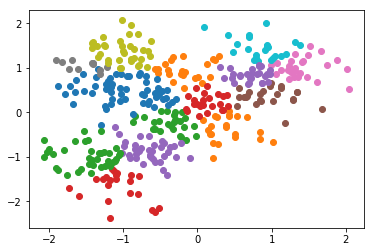

In [627]:
# want > 4 clusters
test_affinity(60, 0.9, -5)

Iter 1 , clusters = 292
Iter 2 , clusters = 99
Iter 3 , clusters = 147
Iter 4 , clusters = 184
Iter 5 , clusters = 202
Iter 6 , clusters = 208
Iter 7 , clusters = 208
Iter 8 , clusters = 228
Iter 9 , clusters = 240
Iter 10 , clusters = 253
Iter 11 , clusters = 256
Iter 12 , clusters = 262
Iter 13 , clusters = 270
Iter 14 , clusters = 265
Iter 15 , clusters = 210
Iter 16 , clusters = 159
Iter 17 , clusters = 133
Iter 18 , clusters = 104
Iter 19 , clusters = 94
Iter 20 , clusters = 84
Iter 21 , clusters = 73
Iter 22 , clusters = 60
Iter 23 , clusters = 49
Iter 24 , clusters = 37
Iter 25 , clusters = 28
Iter 26 , clusters = 22
Iter 27 , clusters = 18
Iter 28 , clusters = 11
Iter 29 , clusters = 7
Iter 30 , clusters = 3
Iter 31 , clusters = 3
Iter 32 , clusters = 3
Iter 33 , clusters = 3
Iter 34 , clusters = 3
Iter 35 , clusters = 3
Iter 36 , clusters = 3
Iter 37 , clusters = 3
Iter 38 , clusters = 3
Iter 39 , clusters = 2
Iter 40 , clusters = 2
Iter 41 , clusters = 2
Iter 42 , clusters = 

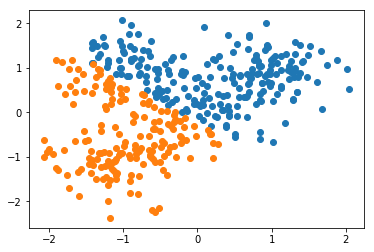

In [628]:
# want < 4 here
test_affinity(60, 0.9, -120)

Iter 1 , clusters = 292
Iter 2 , clusters = 275
Iter 3 , clusters = 223
Iter 4 , clusters = 50
Iter 5 , clusters = 86
Iter 6 , clusters = 114
Iter 7 , clusters = 137
Iter 8 , clusters = 167
Iter 9 , clusters = 195
Iter 10 , clusters = 220
Iter 11 , clusters = 255
Iter 12 , clusters = 279
Iter 13 , clusters = 282
Iter 14 , clusters = 279
Iter 15 , clusters = 266
Iter 16 , clusters = 232
Iter 17 , clusters = 180
Iter 18 , clusters = 126
Iter 19 , clusters = 88
Iter 20 , clusters = 61
Iter 21 , clusters = 40
Iter 22 , clusters = 28
Iter 23 , clusters = 17
Iter 24 , clusters = 13
Iter 25 , clusters = 8
Iter 26 , clusters = 7
Iter 27 , clusters = 7
Iter 28 , clusters = 7
Iter 29 , clusters = 6
Iter 30 , clusters = 5
Iter 31 , clusters = 5
Iter 32 , clusters = 5
Iter 33 , clusters = 5
Iter 34 , clusters = 5
Iter 35 , clusters = 5
Iter 36 , clusters = 5
Iter 37 , clusters = 5
Iter 38 , clusters = 5
Iter 39 , clusters = 4
Iter 40 , clusters = 4
Iter 41 , clusters = 4
Iter 42 , clusters = 4
Ite

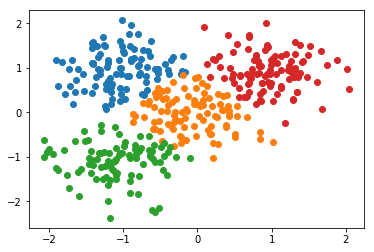

In [629]:
# want 4 here
test_affinity(60, 0.9, -30)

### The end!